# Van Der Pol oscillator physics-informed neural network (PINN)

The Van Der Pol oscillator equation is:


\begin{equation}
 \frac {d^2y} {dt^2} + \omega_0^2 y - \epsilon \omega_0 (1 - y^2)\frac {dy} {dt}  = 0, \\
 \end{equation}
 as one can see in Paper Baty \& Baty (example D with Equation 19).
 

 In this notebook a value $\epsilon = 1$ is taken with $\omega_0 = 15$, and the initial value is $y(t = 0) = 1$ together with $dy/dt (t = 0) = 0$. This is used to produce the bottom panel of Figure 18 in the paper.


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up
We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys

In [2]:
def runge_kutta4(func, r, t, omega, nu, h):
    """ 
    Runge-Kutta 4 method for solving 1st order differential equations
    
    Usage: xNew = rk4(func, r, t, h) 
    
    Given a function  f(x, t, h) = dx/dt and initial starting 
    conditions for x, rk4() returns the next values of x. 
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    """
    k1 = h*func(r, t, omega, nu)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega, nu)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega, nu)
    k4 = h*func(r+k3, t+h, omega, nu)
    return (k1 + 2*k2 + 2*k3 + k4)/6
   
def pendule_Function(r, t, omega, nu):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v
    fv = -omega**2 * x  +  nu*(1 - x**2)*v
    return np.array([fx,fv], float)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

## We first generate the exact solution and a few training data

<function matplotlib.pyplot.show(close=None, block=None)>

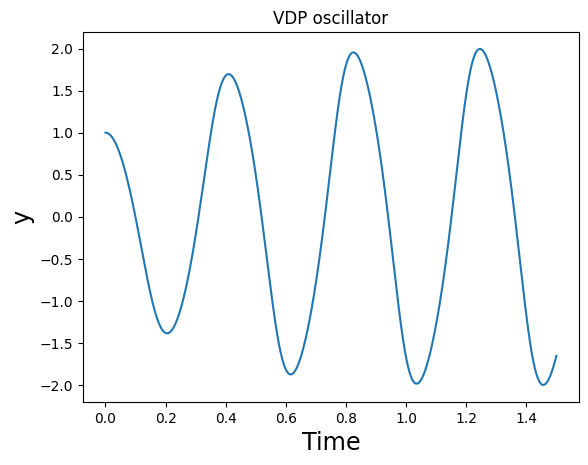

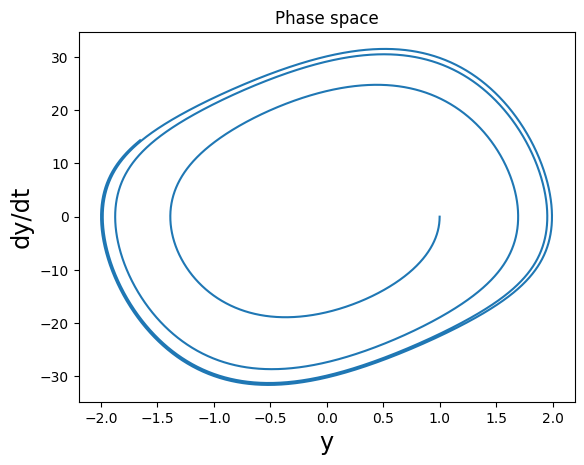

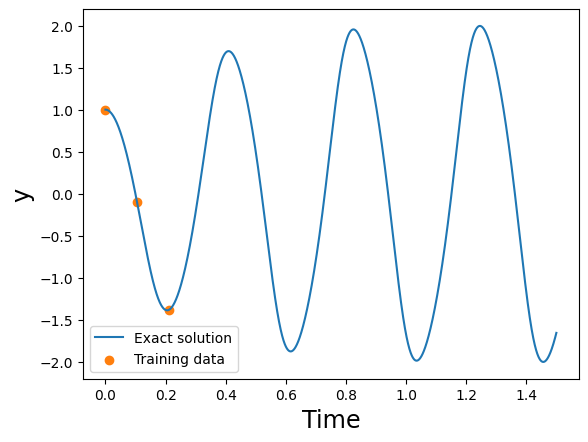

In [3]:
# We define the time step for RK4 numerical integration ... is important also for visualization
nSteps=10000
#Define omega0 and nu parameters .................
w0 = 15.
nu=5.        # This is epsilon * w0 (nu = 5 -> epsilon = 1/3) ...................

# We integrate between tMin and tMax .............
tMin,tMax = 0.0,1.5
tStep = (tMax-tMin)/nSteps

tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

# set initial conditions on the state variables ..........
x0,v0 = 1.,0.
r = np.array([x0,v0], float)

# solve for the time evolution for the true solution obtained with Runge-kutta of order 4 integration
for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, nu, tStep)

# plot displacement vs time  (true solution)  
fig1 = plt.figure(1)
plt.plot(tPoints, xPoints)
plt.xlabel("t")
plt.ylabel("x")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("y",fontsize="xx-large")
plt.title("VDP oscillator")

# plot the phase space (true solution)
fig2 = plt.figure(2)
plt.plot(xPoints, vPoints)
plt.xlabel("y",fontsize="xx-large")
plt.ylabel("dy/dt",fontsize="xx-large")
plt.title("Phase space")

x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

# We select only some points (one over 10 for example) for future comparison with true solution
x = x[::10]
y = y[::10, :]

# We select a very few data points to be used in the normal Neural netwok -> training data ...
x_data=x[0:210:70]
y_data=y[0:210:70]

# We plot data of the true solution and the training data .............................
plt.figure()
plt.plot(tPoints, xPoints, label="Exact solution")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("y",fontsize="xx-large")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show


## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

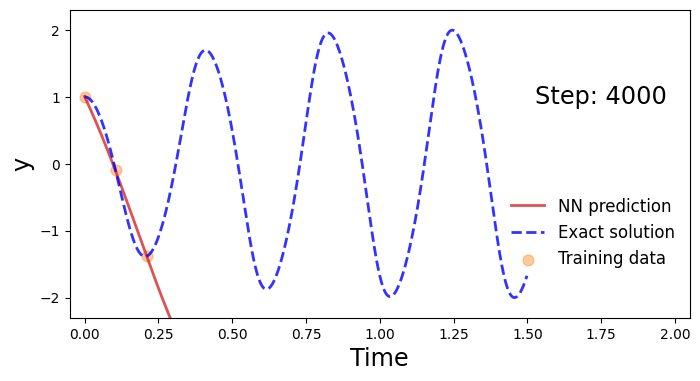

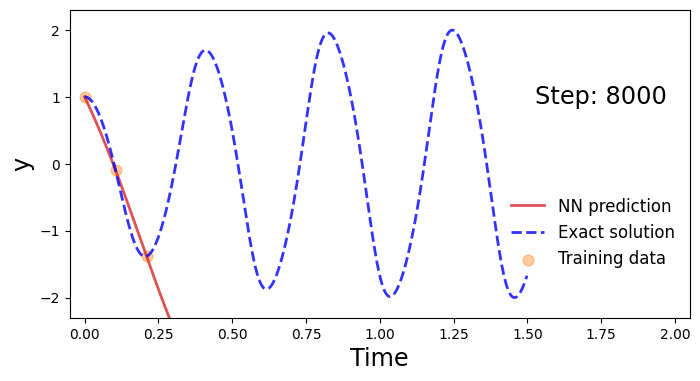

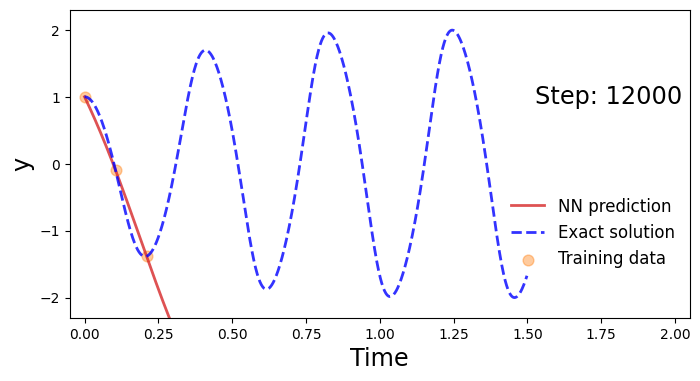

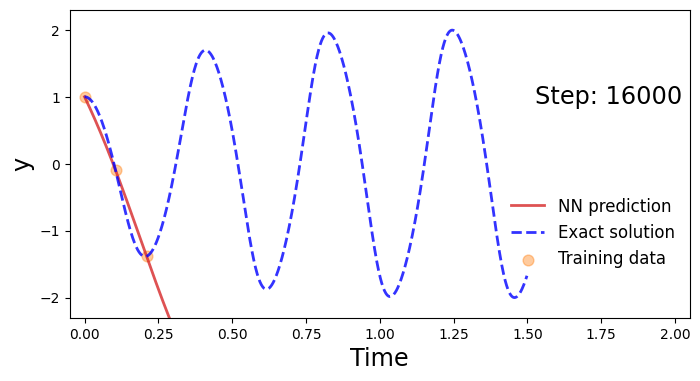

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Coloc. points')
    l = plt.legend(loc=(0.701,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05,2.05)
    plt.ylim(-2.3, 2.3)
    plt.text(1.525,0.9,"Step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
        
# We train a standard neural network to fit training data (one must choos lr and number of
# layers, number of neurons per layer) ....................................................
torch.manual_seed(127)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(16000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error to define Loss on data ......
    loss.backward()
    optimizer.step()
        
    # plot the result as training progresses ..............................................
    if (i+1) % 100 == 0:         
        yh = model(x).detach()       
        plot_result(x,y,x_data,y_data,yh)   
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.


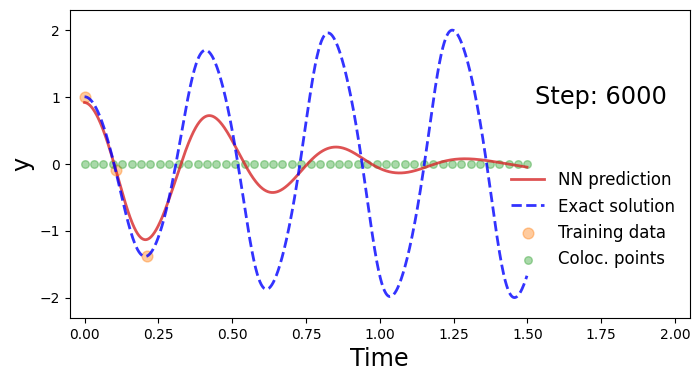

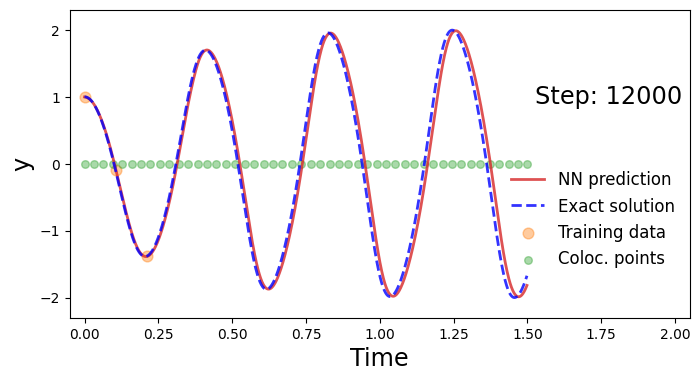

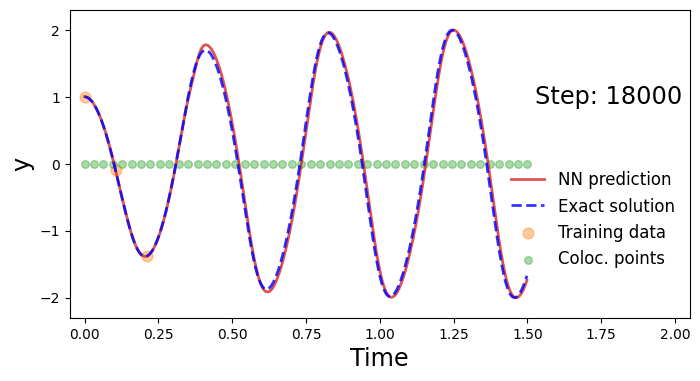

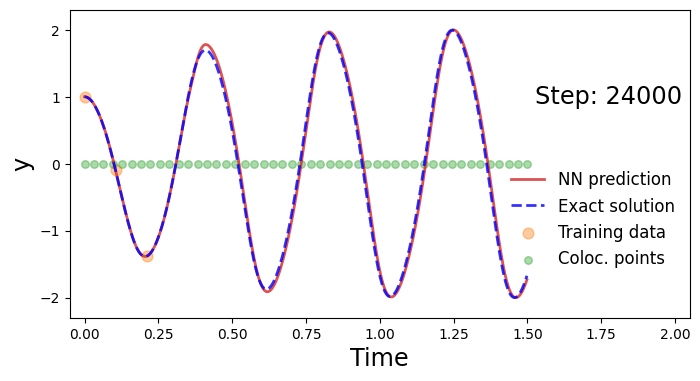

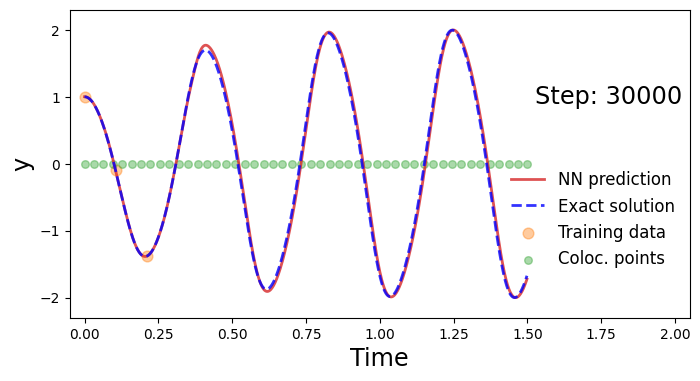

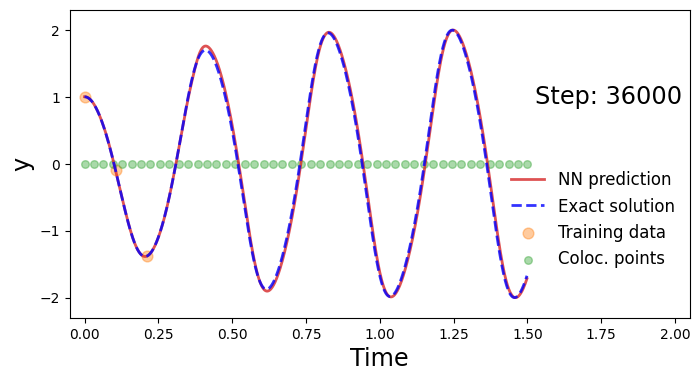

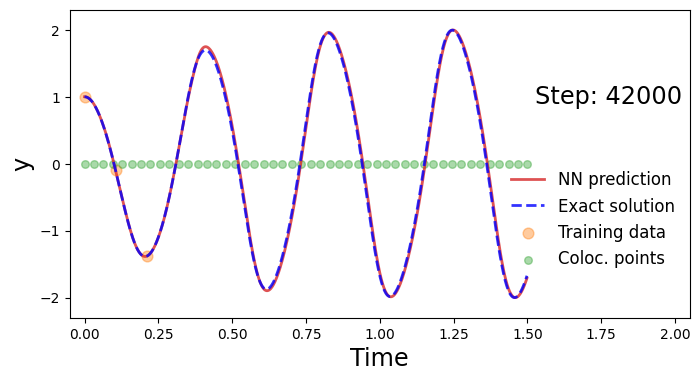

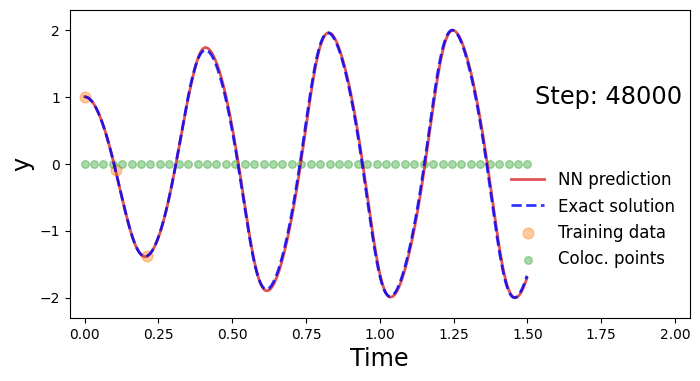

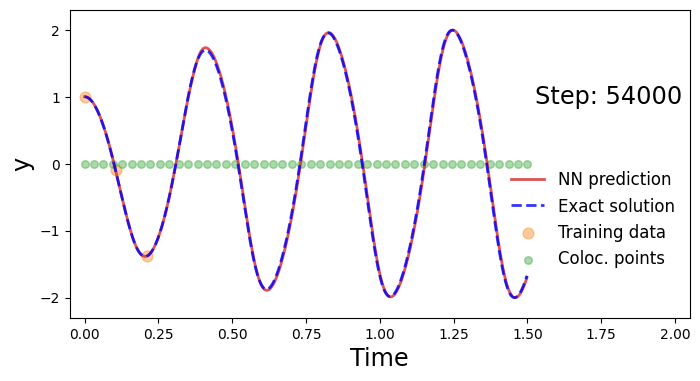

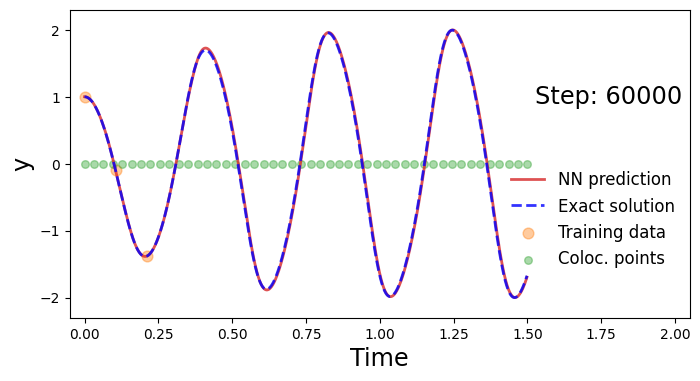

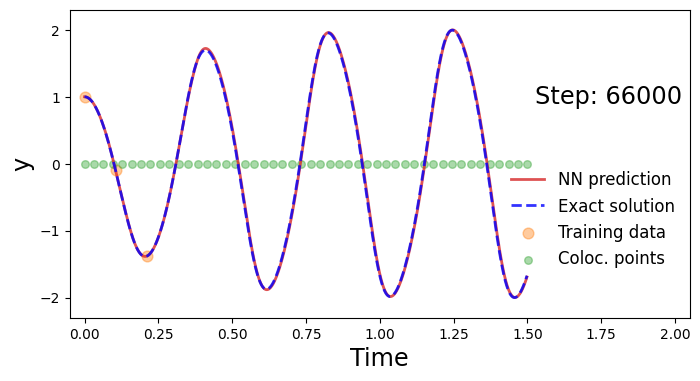

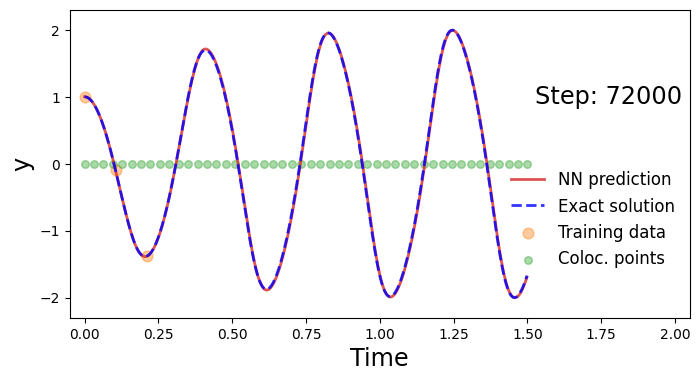

In [5]:
# We define the collocation data points .......................................................................
x_physics = torch.linspace(0.,1.5,48).view(-1,1).requires_grad_(True)# sample locations over the problem domain
ww=w0
torch.manual_seed(123)
model = FCN(1,1,32,3)

optimizer = torch.optim.Adam(model.parameters(),lr=7e-4)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

for i in range(72000):
    
    optimizer.zero_grad()
    
    # compute the "data loss" ...................................................................
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)  # use mean squared error (the weight is taken to be 1)
    
    # compute the "physics loss" with enforcing the initial data ...............................
    yhp = model(x_physics)
    # compute first and second derivatives by automatic differentiation .........................
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2   
    # computes the residual ...................................................................
    physics= (dx2 + ww**2*yhp - nu*(1 - yhp*yhp)*dx)   # This is the equation ................
    loss2 = (1e-4)*torch.mean(physics**2) *1   # Loss on physicq with a chosen weight ..........
    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution ............

    # backpropagate the total loss .......................................................
    loss = loss1 + loss2  # add two loss terms together ..................................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    if (i+1) % 150 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())
        mse_history.append(mse.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
           
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            

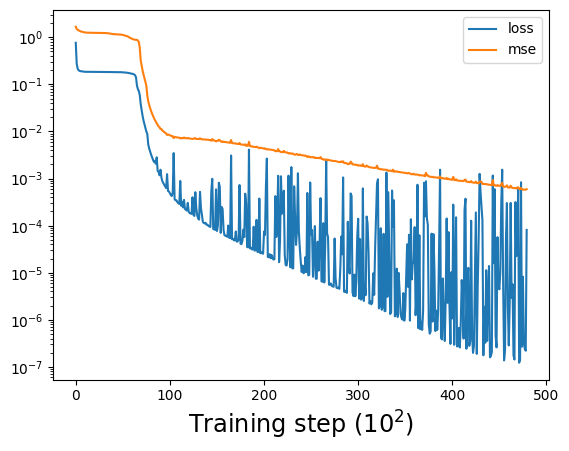

In [6]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

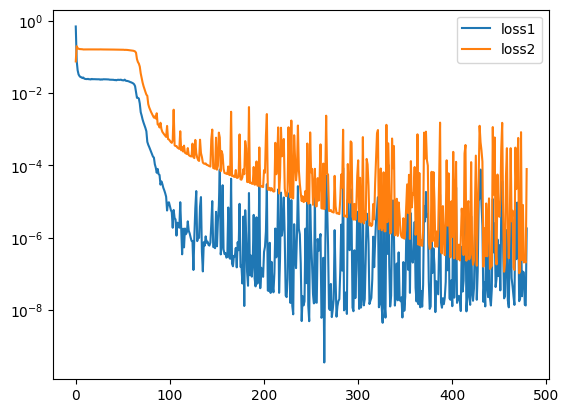

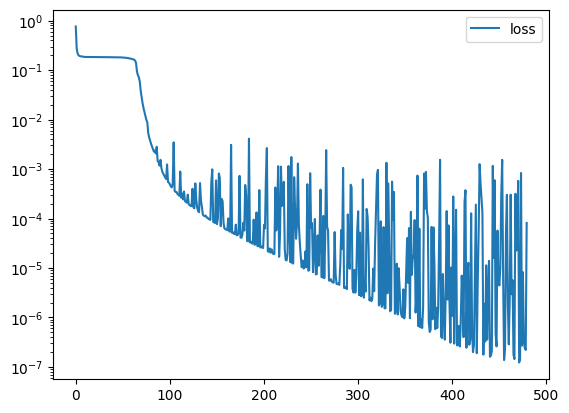

In [7]:
fig50 = plt.figure(50)
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'error')

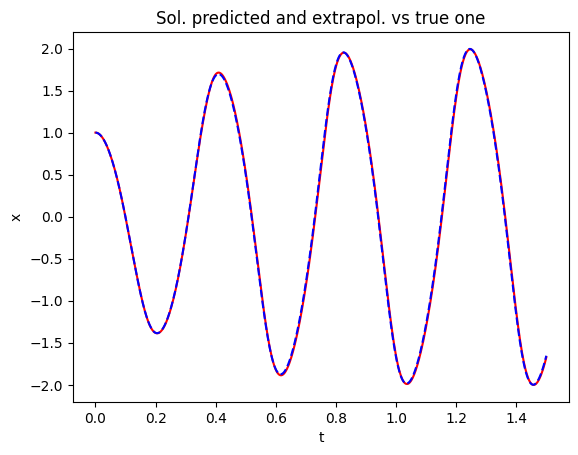

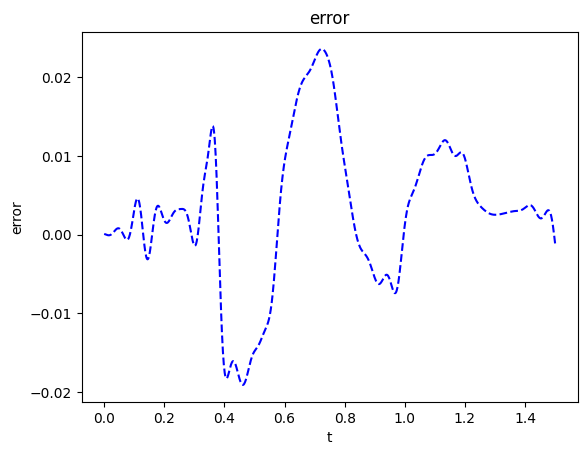

In [8]:
xn = torch.linspace(0.,1.5,1000).view(-1,1)
yh2 = model(xn).detach()
        
# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, yh2, color="red")
plt.plot(tPoints, xPoints, color="blue",linestyle='--')
#plt.plot(xn, yth)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sol. predicted and extrapol. vs true one")

err=y-yh2

fig6 = plt.figure(6)
plt.plot(xn, err, color="blue",linestyle='--')
#plt.plot(xn, yth)
plt.xlabel("t")
plt.ylabel("error")
plt.title("error")


